In [1]:
import jax
import jax.numpy as np
import jax.random as jnp_random
import numpy as onp
from jax import grad, jacrev, jacfwd, jit, vmap, partial
from jax.scipy.special import logsumexp
from jax.lax import scan
from jax.ops import index, index_add, index_update
from jax.experimental import optimizers
from jax.numpy import concatenate as cat
import timeit

import random
import pickle as pkl
import scipy

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [18]:
@jit
def p(x): # uniform distribution
    return np.exp(-50.5 * np.sum((x[:2] - 0.3)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - 0.65)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - np.array([0.3, 0.55]))**2))

@jit
def f(x, u): # dynamics
    xnew = x + u
    return xnew, xnew

def get_hk(k): # normalizing factor for basis function
    _hk = (2. * k + onp.sin(2 * k))/(4. * k)
    _hk[onp.isnan(_hk)] = 1.
    return onp.sqrt(onp.prod(_hk))

def fk(x, k): # basis function
    return np.prod(np.cos(x*k))


k1, k2 = np.meshgrid(*[np.arange(0, 6, step=1)]*2)
k = np.stack([k1.ravel(), k2.ravel()]).T
k = np.pi*k

# lamk = (1.+np.linalg.norm(k/np.pi,axis=1)**2)**(-4./2.)
lamk = np.exp(-0.8 * np.linalg.norm(k/np.pi, axis=1))
# lamk = np.ones((len(k), 1))
hk = []
for ki in k:
    hk.append(get_hk(ki))
hk = np.array(hk)

fk_vmap = lambda _x, _k: vmap(fk, in_axes=(0,None))(_x, _k)
def get_ck(tr, k):
    ck = np.mean(vmap(partial(fk_vmap, tr))(k), axis=1)
    ck = ck / hk
    return ck

# @jit
def fourier_ergodic_loss(u, x0, phik, k, history):
    xf, tr = scan(f, x0, u)
    tr = cat([tr, history], axis=0)
    ck = get_ck(tr, k)
    return np.sum(lamk*np.square(phik - ck)) \
            + 1e-3 * np.mean(u**2) + np.mean((tr - np.array([0.5,0.5]))**12)

dl = jit(grad(fourier_ergodic_loss))

<ipython-input-18-fd23930145c2>:13: RuntimeWarning: invalid value encountered in true_divide
  _hk = (2. * k + onp.sin(2 * k))/(4. * k)


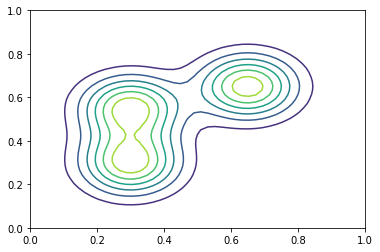

In [19]:
X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
_s = np.stack([X.ravel(), Y.ravel()]).T
plt.contour(X, Y, vmap(p)(_s).reshape(X.shape))

In [20]:
phik = np.dot(vmap(fk_vmap, in_axes=(None, 0))(_s, k), vmap(p)(_s))
phik = phik/phik[0]
phik = phik/hk

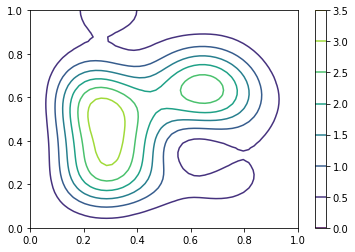

In [21]:
phik_recon = np.dot(phik, vmap(fk_vmap, in_axes=(None, 0))(_s, k)).reshape(X.shape)
plt.contour(X, Y, phik_recon)
plt.colorbar()

In [22]:
# initial conditions
x0 = np.array([0.54,0.3])
u  = np.zeros((100,2))

In [23]:
fourier_ergodic_loss(u, x0, phik, k, x0.reshape(1,-1))

DeviceArray(1.9532032, dtype=float32)

In [24]:
# opt_init, opt_update, get_params = optimizers.adam(1e-3)
# opt_state = opt_init(u)

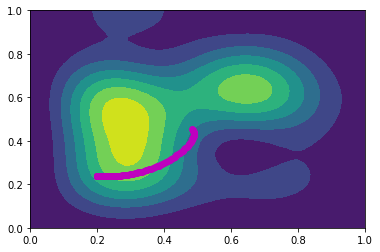

KeyboardInterrupt: 

In [25]:
log = []
history = []
for i in range(1500):
    history.append(x0.copy())
    g = dl(u, x0, phik, k, np.stack(history[-100:]))
    u = u - 1e-3 * g
#     opt_state = opt_update(i, g, opt_state)
#     u = get_params(opt_state)
    x0, _ = f(x0, u[0])
    u = index_update(u, index[:-1,:], u[1:,:])
    u = index_update(u, index[-1,:], 0.)
    if (i+1) % 10 == 0:
#         u = get_params(opt_state)
        log.append(fourier_ergodic_loss(u, x0, phik, k, np.stack(history[-10:])).copy())
        clear_output(wait=True)
        xf, tr = scan(f, x0, u)
        
        clear_output(wait=True)
        plt.contourf(X, Y, phik_recon)
        plt.scatter(tr[:,0],tr[:,1], c='m')
#         plt.ylim(0,1)
#         plt.xlim(0,1)
        plt.pause(0.001)
        i+=1
        plt.show()


In [ ]:
# ck reconstruction
ck = get_ck(tr, k)
ck_recon = np.dot(ck, vmap(fk_vmap, in_axes=(None, 0))(_s, k)).reshape(X.shape)
plt.contour(X, Y, ck_recon)
plt.scatter(tr[:,0],tr[:,1], c='m')
plt.colorbar()